In [1]:
# Connect to Google Drive 
# Upload the dataset to your Google drive so it can be loaded here

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# First we import the required libraries

import tensorflow as tf
import random
import numpy as np
import pandas as pd
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
import io
import re
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K 
K.clear_session()

# Check tensorflow version
if float(tf.__version__[0]) < 2.0:
  print('Updating tensorflow')
  !pip install tensorflow==2.0
else:
  print('Correct version of Tensorflow installed.')

Correct version of Tensorflow installed.


In [3]:
# import pandas lib as pd
import pandas as pd
 
# read by default 1st sheet of an excel file
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Testing FNH dataset/RandomOverSampler_withFeatures.xlsx', 'Sheet1')
 
print(df)
df = df.fillna(' ')
df.count()

                                                   Title    Len  \
0      White house asks congress for funding on afgha...   3192   
1      Fear of ebola as congolese caught crossing us-...   1315   
2      Sunday screening: better brain health: we are ...   1095   
3                                Trump's weird fed tweet  14123   
4      States pushing back january enrollment deadlin...    233   
...                                                  ...    ...   
14860  Worrying new coronavirus variants aren't just ...  10096   
14861  Lawmakers respond to industry outcry with flex...   1085   
14862  Senate dems to try to stop doj's funding for o...   1914   
14863  Tn primary heats up: name calling and attack a...   2798   
14864  Many considering getting a shingle shot opting...    118   

                                                 Content  \
0      President joe biden's aides on tuesday asked c...   
1      A public health official in laredo, texas, sai...   
2      It appea

Title      14865
Len        14865
Content    14865
Source     14865
Smog       14865
TTR        14865
Label      14865
dtype: int64

In [4]:
# Normalize the dataset
def normalize(data):
    normalized = []
    for i in data:
        i = i.lower()
        # get rid of urls
        i = re.sub('https?://\S+|www\.\S+', '', i)
        # get rid of non words and extra spaces
        i = re.sub('\\W', ' ', i)
        i = re.sub('\n', '', i)
        i = re.sub(' +', ' ', i)
        i = re.sub('^ ', '', i)
        i = re.sub(' $', '', i)
        normalized.append(i)
    return normalized

df['Content'] = normalize(df['Content'])

In [5]:
# Tokenize text

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Content'])
word_index = tokenizer.word_index
vocab_size=len(word_index)
print(vocab_size)

# Padding data

sequences = tokenizer.texts_to_sequences(df['Content'])
padded = pad_sequences(sequences, maxlen=500, padding='post', truncating='post')

90999


**Split 70:30** 

In [6]:
# Spliting data
split = 0.3
split_n = int(round(len(padded)*(1-split),0))

train_data = padded[:split_n]
train_labels = df['Label'].values[:split_n]
test_data = padded[split_n:]
test_labels = df['Label'].values[split_n:]

print("Train label","/n",train_labels)
print("/nTest label","/n",test_labels)

print(type(train_data))
print(len(train_data))
print(type(train_labels))
print(len(train_labels))

Train label /n [0 1 1 ... 0 1 1]
/nTest label /n [0 1 1 ... 0 1 1]
<class 'numpy.ndarray'>
10406
<class 'numpy.ndarray'>
10406


In [7]:
# Import tensor representations for words - GloVe Embedding
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt
embeddings_index = {};
with open('/content/drive/MyDrive/Colab Notebooks/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;
print(len(coefs))

embeddings_matrix = np.zeros((vocab_size+1, 100));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

--2023-02-20 03:59:41--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.115.128, 142.251.167.128, 172.253.63.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.115.128|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2023-02-20 03:59:42 ERROR 404: Not Found.

100


In [8]:
# Build the architecture of the RNN model
     
model_7030 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, 100, weights=[embeddings_matrix], trainable=False),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(20, return_sequences=True),
    tf.keras.layers.LSTM(20),
    #tf.keras.layers.Dropout(0.2),  
    tf.keras.layers.Dense(512),
    tf.keras.layers.Dropout(0.3),  
    tf.keras.layers.Dense(256),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [9]:
model_7030.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_7030.summary()

history_7030 = model_7030.fit(train_data, train_labels, epochs=44, batch_size=200, validation_data=[test_data, test_labels])

print("Training Complete")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         9100000   
                                                                 
 conv1d (Conv1D)             (None, None, 64)          32064     
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 64)         0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, None, 20)          6800      
                                                                 
 lstm_1 (LSTM)               (None, 20)                3280      
                                                                 
 dense (Dense)               (None, 512)               10752     
                                                        

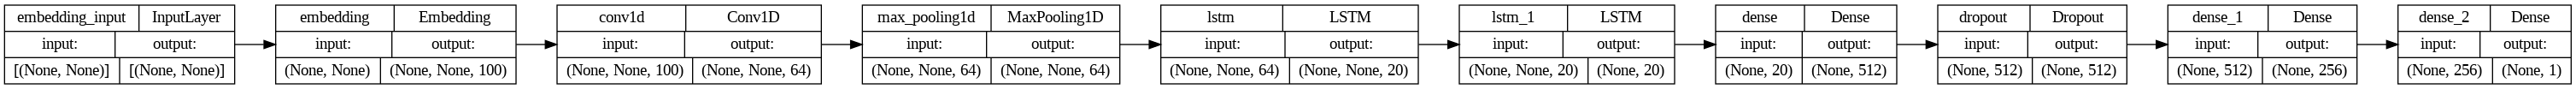

In [10]:
tf.keras.utils.plot_model(model_7030, show_shapes=True, rankdir="LR")

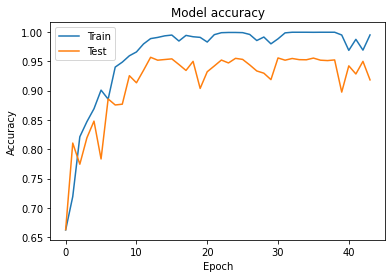

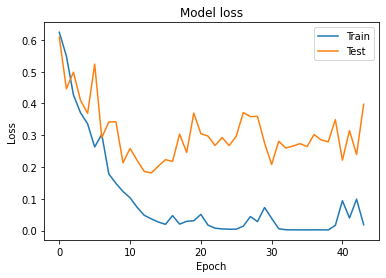

In [11]:
# Visualize the results:

plt.plot(history_7030.history['accuracy'])
plt.plot(history_7030.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history_7030.history['loss'])
plt.plot(history_7030.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [12]:
pred_7030 = model_7030.predict(test_data)

binary_predictions_7030 = []

for i in pred_7030:
    if i >= 0.5:
        binary_predictions_7030.append(1)
    else:
        binary_predictions_7030.append(0) 

140/140 [==============================] - 1s 6ms/step


[Text(0, 0.5, 'True News'), Text(0, 1.5, 'Fake News')]

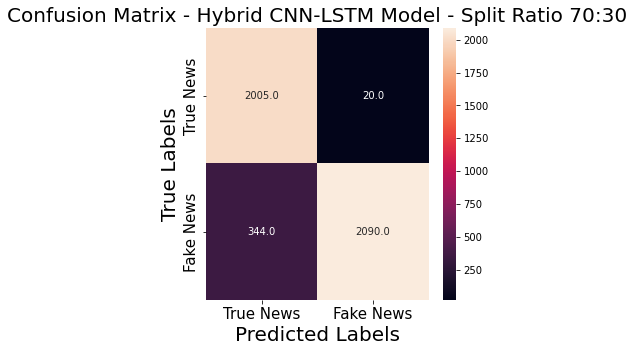

In [13]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(binary_predictions_7030, test_labels)
plt.figure(figsize=(5, 5))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax, fmt = ".1f")

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix - Hybrid CNN-LSTM Model - Split Ratio 70:30', size=20) 
ax.xaxis.set_ticklabels(['True News','Fake News'], size=15)
ax.yaxis.set_ticklabels(['True News','Fake News'], size=15)

In [14]:
# Precision, recall, accuracy score and F1 score

from sklearn import metrics
Accuracy_7030 = metrics.accuracy_score(test_labels, binary_predictions_7030)
Precision_7030 = metrics.precision_score(test_labels, binary_predictions_7030)
Sensitivity_recall_7030 = metrics.recall_score(test_labels, binary_predictions_7030)
Specificity_7030 = metrics.recall_score(test_labels, binary_predictions_7030, pos_label=0)
F1_score_7030 = metrics.f1_score(test_labels, binary_predictions_7030)

print("Accuracy of 70:30 Model (Hybrid CNN-LSTM) =", Accuracy_7030)
print("Precision of 70:30 Model (Hybrid CNN-LSTM) =", Precision_7030)
print("Sensitivity_recall of 70:30 Model (Hybrid CNN-LSTM) =", Sensitivity_recall_7030)
print("Specificity of Model 70:30 (Hybrid CNN-LSTM) =", Specificity_7030)
print("F1_score of Model 70:30 (Hybrid CNN-LSTM) =", F1_score_7030)


Accuracy of 70:30 Model (Hybrid CNN-LSTM) = 0.9183673469387755
Precision of 70:30 Model (Hybrid CNN-LSTM) = 0.8586688578471652
Sensitivity_recall of 70:30 Model (Hybrid CNN-LSTM) = 0.990521327014218
Specificity of Model 70:30 (Hybrid CNN-LSTM) = 0.8535547041294168
F1_score of Model 70:30 (Hybrid CNN-LSTM) = 0.9198943661971831


**Split 90:10** 

In [15]:
# Spliting data
split = 0.1
split_n = int(round(len(padded)*(1-split),0))

train_data = padded[:split_n]
train_labels = df['Label'].values[:split_n]
test_data = padded[split_n:]
test_labels = df['Label'].values[split_n:]

print("Train label","/n",train_labels)
print("/nTest label","/n",test_labels)

print(type(train_data))
print(len(train_data))
print(type(train_labels))
print(len(train_labels))

Train label /n [0 1 1 ... 1 1 1]
/nTest label /n [1 1 0 ... 0 1 1]
<class 'numpy.ndarray'>
13378
<class 'numpy.ndarray'>
13378


In [16]:
# Import tensor representations for words - GloVe Embedding
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt
embeddings_index = {};
with open('/content/drive/MyDrive/Colab Notebooks/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;
print(len(coefs))

embeddings_matrix = np.zeros((vocab_size+1, 100));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

--2023-02-20 04:01:26--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.16.128, 172.253.62.128, 172.253.115.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.16.128|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2023-02-20 04:01:26 ERROR 404: Not Found.

100


In [17]:
# Build the architecture of the RNN model
     
model_9010 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, 100, weights=[embeddings_matrix], trainable=False),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(20, return_sequences=True),
    tf.keras.layers.LSTM(20),
    #tf.keras.layers.Dropout(0.2),  
    tf.keras.layers.Dense(512),
    tf.keras.layers.Dropout(0.3),  
    tf.keras.layers.Dense(256),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [18]:
model_9010.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_9010.summary()

history_9010 = model_9010.fit(train_data, train_labels, epochs=44, batch_size=200, validation_data=[test_data, test_labels])

print("Training Complete")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 100)         9100000   
                                                                 
 conv1d_1 (Conv1D)           (None, None, 64)          32064     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 64)         0         
 1D)                                                             
                                                                 
 lstm_2 (LSTM)               (None, None, 20)          6800      
                                                                 
 lstm_3 (LSTM)               (None, 20)                3280      
                                                                 
 dense_3 (Dense)             (None, 512)               10752     
                                                      

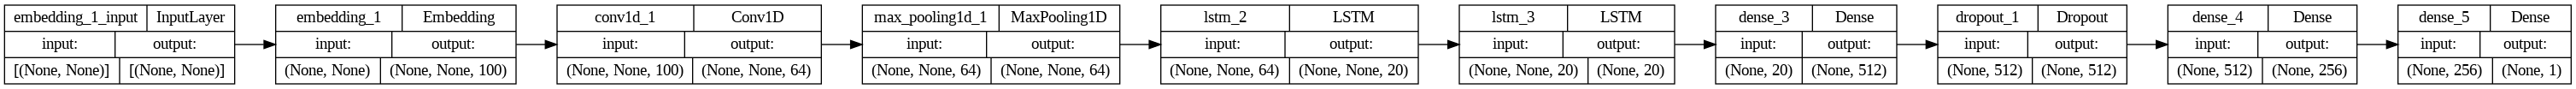

In [19]:
tf.keras.utils.plot_model(model_9010, show_shapes=True, rankdir="LR")

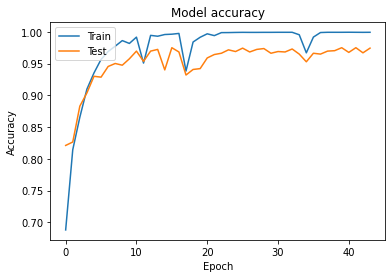

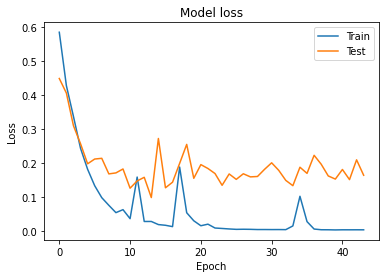

In [20]:
# Visualize the results:

plt.plot(history_9010.history['accuracy'])
plt.plot(history_9010.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history_9010.history['loss'])
plt.plot(history_9010.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [21]:
pred_9010 = model_9010.predict(test_data)

binary_predictions_9010 = []

for i in pred_9010:
    if i >= 0.5:
        binary_predictions_9010.append(1)
    else:
        binary_predictions_9010.append(0) 

47/47 [==============================] - 1s 8ms/step


[Text(0, 0.5, 'True News'), Text(0, 1.5, 'Fake News')]

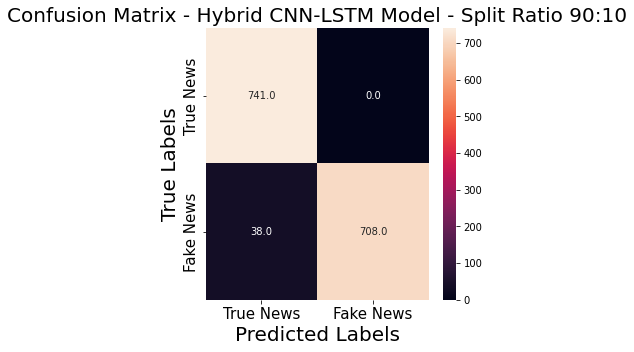

In [22]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(binary_predictions_9010, test_labels)
plt.figure(figsize=(5, 5))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax, fmt = ".1f")

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix - Hybrid CNN-LSTM Model - Split Ratio 90:10', size=20) 
ax.xaxis.set_ticklabels(['True News','Fake News'], size=15)
ax.yaxis.set_ticklabels(['True News','Fake News'], size=15)

In [23]:
# Precision, recall, accuracy score and F1 score

from sklearn import metrics
Accuracy_9010 = metrics.accuracy_score(test_labels, binary_predictions_9010)
Precision_9010 = metrics.precision_score(test_labels, binary_predictions_9010)
Sensitivity_recall_9010 = metrics.recall_score(test_labels, binary_predictions_9010)
Specificity_9010 = metrics.recall_score(test_labels, binary_predictions_9010, pos_label=0)
F1_score_9010 = metrics.f1_score(test_labels, binary_predictions_9010)

print("Accuracy of 90:10 Model (Hybris CNN-LSTM) =", Accuracy_9010)
print("Precision of 90:10 Model (Hybrid CNN-LSTM) =", Precision_9010)
print("Sensitivity_recall of 90:10 Model (Hybrid CNN-LSTM) =", Sensitivity_recall_9010)
print("Specificity of Model 90:10 (Hybrid CNN-LSTM) =", Specificity_9010)
print("F1_score of Model 90:10 (Hybrid CNN-LSTM) =", F1_score_9010)

Accuracy of 90:10 Model (Hybris CNN-LSTM) = 0.9744451916610626
Precision of 90:10 Model (Hybrid CNN-LSTM) = 0.9490616621983914
Sensitivity_recall of 90:10 Model (Hybrid CNN-LSTM) = 1.0
Specificity of Model 90:10 (Hybrid CNN-LSTM) = 0.9512195121951219
F1_score of Model 90:10 (Hybrid CNN-LSTM) = 0.9738651994497937


**Split Ratio 80:20**

In [24]:
# Spliting data
split = 0.2
split_n = int(round(len(padded)*(1-split),0))

train_data = padded[:split_n]
train_labels = df['Label'].values[:split_n]
test_data = padded[split_n:]
test_labels = df['Label'].values[split_n:]

print("Train label","/n",train_labels)
print("/nTest label","/n",test_labels)

print(type(train_data))
print(len(train_data))
print(type(train_labels))
print(len(train_labels))

Train label /n [0 1 1 ... 1 1 0]
/nTest label /n [1 0 0 ... 0 1 1]
<class 'numpy.ndarray'>
11892
<class 'numpy.ndarray'>
11892


In [35]:
# Import tensor representations for words - GloVe Embedding
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt
embeddings_index = {};
with open('/content/drive/MyDrive/Colab Notebooks/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;
print(len(coefs))

embeddings_matrix = np.zeros((vocab_size+1, 100));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

--2023-02-20 04:07:29--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.115.128, 172.253.122.128, 172.253.63.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.115.128|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2023-02-20 04:07:29 ERROR 404: Not Found.

100


In [55]:
# Build the architecture of the RNN model
     
model_8020 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, 100, weights=[embeddings_matrix], trainable=False),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(20, return_sequences=True),
    tf.keras.layers.LSTM(20),
    #tf.keras.layers.Dropout(0.2),  
    tf.keras.layers.Dense(512),
    tf.keras.layers.Dropout(0.3),  
    tf.keras.layers.Dense(256),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [69]:
model_8020.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_8020.summary()

history_8020 = model_8020.fit(train_data, train_labels, epochs=44, batch_size=200, validation_data=[test_data, test_labels])

print("Training Complete")

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 100)         9100000   
                                                                 
 conv1d_6 (Conv1D)           (None, None, 64)          32064     
                                                                 
 max_pooling1d_6 (MaxPooling  (None, None, 64)         0         
 1D)                                                             
                                                                 
 lstm_12 (LSTM)              (None, None, 20)          6800      
                                                                 
 lstm_13 (LSTM)              (None, 20)                3280      
                                                                 
 dense_18 (Dense)            (None, 512)               10752     
                                                      

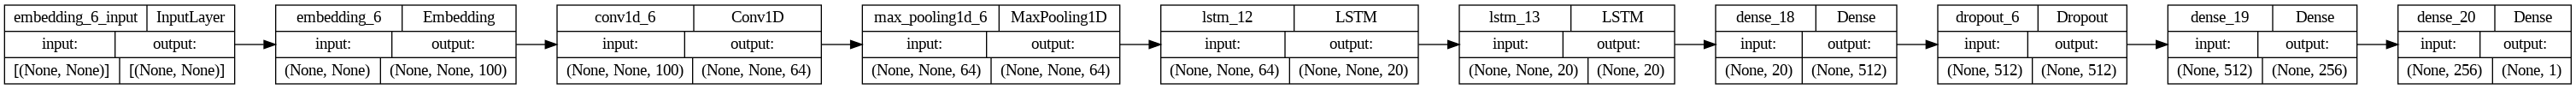

In [70]:
tf.keras.utils.plot_model(model_8020, show_shapes=True, rankdir="LR")

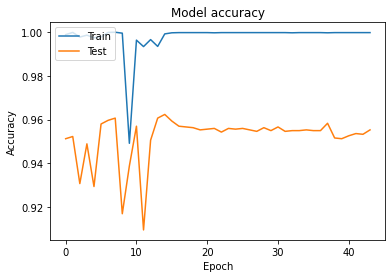

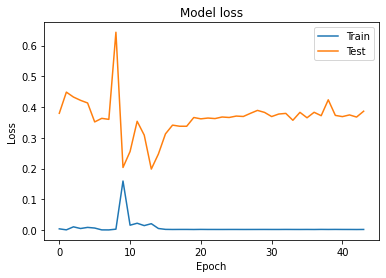

In [71]:
# Visualize the results:

plt.plot(history_8020.history['accuracy'])
plt.plot(history_8020.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history_8020.history['loss'])
plt.plot(history_8020.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [72]:
pred_8020 = model_8020.predict(test_data)

binary_predictions_8020 = []

for i in pred_8020:
    if i >= 0.5:
        binary_predictions_8020.append(1)
    else:
        binary_predictions_8020.append(0) 

93/93 [==============================] - 1s 6ms/step


[Text(0, 0.5, 'True News'), Text(0, 1.5, 'Fake News')]

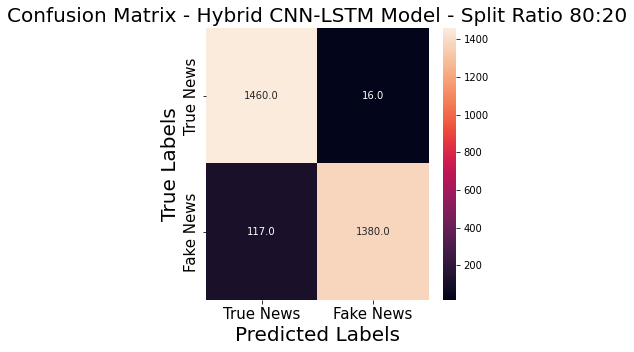

In [73]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(binary_predictions_8020, test_labels)
plt.figure(figsize=(5, 5))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax, fmt = ".1f")

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix - Hybrid CNN-LSTM Model - Split Ratio 80:20', size=20) 
ax.xaxis.set_ticklabels(['True News','Fake News'], size=15)
ax.yaxis.set_ticklabels(['True News','Fake News'], size=15)

In [74]:
# Precision, recall, accuracy score and F1 score

from sklearn import metrics
Accuracy_8020 = metrics.accuracy_score(test_labels, binary_predictions_8020)
Precision_8020 = metrics.precision_score(test_labels, binary_predictions_8020)
Sensitivity_recall_8020 = metrics.recall_score(test_labels, binary_predictions_8020)
Specificity_8020 = metrics.recall_score(test_labels, binary_predictions_8020, pos_label=0)
F1_score_8020 = metrics.f1_score(test_labels, binary_predictions_8020)

print("Accuracy of 80:20 Model (Hybrid CNN-LSTM) =", Accuracy_8020)
print("Precision of 80:20 Model (Hybrid CNN-LSTM) =", Precision_8020)
print("Sensitivity_recall of 80:20 Model (Hybrid CNN-LSTM) =", Sensitivity_recall_8020)
print("Specificity of Model 80:20 (Hybrid CNN-LSTM) =", Specificity_8020)
print("F1_score of Model 80:20 (Hybrid CNN-LSTM) =", F1_score_8020)

Accuracy of 80:20 Model (Hybrid CNN-LSTM) = 0.955264043054154
Precision of 80:20 Model (Hybrid CNN-LSTM) = 0.9218436873747495
Sensitivity_recall of 80:20 Model (Hybrid CNN-LSTM) = 0.9885386819484241
Specificity of Model 80:20 (Hybrid CNN-LSTM) = 0.9258084971464806
F1_score of Model 80:20 (Hybrid CNN-LSTM) = 0.9540269616315243


# **Comparision of Models**

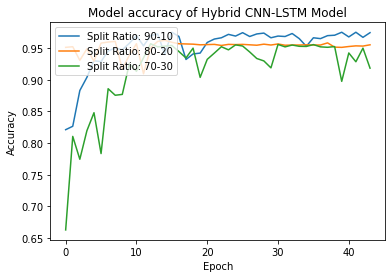

In [75]:
# Accuracy comparision

plt.plot(history_9010.history['val_accuracy'])
plt.plot(history_8020.history['val_accuracy'])
plt.plot(history_7030.history['val_accuracy'])

plt.title('Model accuracy of Hybrid CNN-LSTM Model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Split Ratio: 90-10', 'Split Ratio: 80-20', 'Split Ratio: 70-30'], loc='upper left')
plt.show()


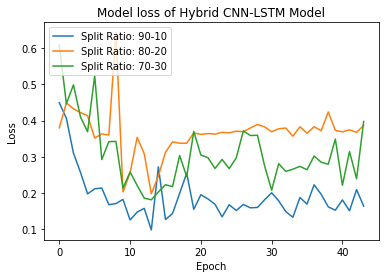

In [76]:
# Loss Comparision
plt.plot(history_9010.history['val_loss'])
plt.plot(history_8020.history['val_loss'])
plt.plot(history_7030.history['val_loss'])

plt.title('Model loss of Hybrid CNN-LSTM Model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Split Ratio: 90-10', 'Split Ratio: 80-20', 'Split Ratio: 70-30'], loc='upper left')
plt.show()